In [1]:
import cv2
import matplotlib.pyplot as plt
import openface
import os
from IPython import display
import pickle
import index
import numpy as np

%matplotlib inline

In [2]:
nnet = openface.TorchNeuralNet('../openface/models/openface/nn4.small2.v1.t7')
align = openface.AlignDlib('../openface/models/dlib/shape_predictor_68_face_landmarks.dat')

NNET_INP_SHAPE = 96
NNET_OUT_SHAPE = 128

In [3]:
def imread(fname):
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def read_imgs(path):
    fnames = [os.path.join(path, x) for x in os.listdir(path)]
    images = []
    for fname in fnames:
        images.append(imread(fname))
    return images

def build_index_from(path_to_faces):
    fnames = os.listdir(path_to_faces)
    vector_index = index.RecommenderVectorIndex(NNET_OUT_SHAPE, n_trees=32)
    data = np.zeros((len(fnames), NNET_OUT_SHAPE))
    images = read_imgs(path_to_faces)
    for i, fname in enumerate(fnames):
        image = images[i]
        alignedFace = align.align(NNET_INP_SHAPE, image, landmarkIndices=openface.AlignDlib.OUTER_EYES_AND_NOSE)
        try:
            vector = nnet.forward(alignedFace)
        except:
            print i
            print fname
            plt.imshow(image)
            plt.show()
        
        data[i] = vector
        images.append(image)
    vector_index.fill_build(data)
    return vector_index, images


### COPY-PASTE FROM "extract_frames_from_video.ipynb"
def mark_image_with_rectangles(image, rectangles):
    image = image.copy()
    for rect in rectangles:
        pt1 = (rect.left(), rect.top())
        pt2 = (rect.right(), rect.bottom())
        cv2.rectangle(image, pt1, pt2, (0, 255, 0), 2)
    return image

In [4]:
vector_index, putin_faces_images = build_index_from('./putin_faces/')

INFO:index:Fill 1 indices.
INFO:index:INSERTing 329 vectors.
INFO:index:Building index.


In [5]:
putin_faces_fnames = os.listdir('./putin_faces/')

In [60]:
vector_index.save('index_putin_faces.dump')

INFO:index:Save index #0 to index_putin_faces.dump0


In [6]:
frames_images = read_imgs('./extracted_frames/')
import pickle
frames_fnames = os.listdir('./extracted_frames/')
with open('./labeled.pkl', 'rb') as f:
    fname2label = pickle.load(f)

In [72]:
len(frames_images), len(frames_fnames), len(fname2label)

(706, 706, 706)

In [7]:
frames_labels = [fname2label[fname] for fname in frames_fnames]

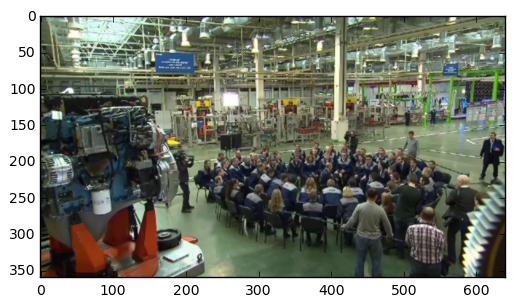

In [24]:
plt.imshow(frames_images[0])

In [8]:
def process_frame(image):
    bbs = align.getAllFaceBoundingBoxes(image)
    if len(bbs) == 0:
        print "NOT FOUND ANY FACES ON THE FRAME IMAGE! FUCK"
        plt.imshow(image)
        plt.show()
        return
    for bb in bbs:
        print "PROCESS THIS FACE:"
        marked_image = mark_image_with_rectangles(image, [bb])
        plt.imshow(marked_image)
        plt.show()
        alignedFace = align.align(NNET_INP_SHAPE, image, bb, landmarkIndices=openface.AlignDlib.OUTER_EYES_AND_NOSE)
        vector = nnet.forward(alignedFace)
        neighb_ids, dists = vector_index.get_nns_by_vector(vector, 3, search_k=10)
        print "NEAREST NEIGHBORS IN ANNOY INDEX:"
        for n_id, dist in zip(neighb_ids, dists):
            print "ID:\t{0};\tFNAME:\t{1};\tDIST:\t{2:.3f}".format(n_id, putin_faces_fnames[n_id], dist)
            plt.imshow(putin_faces_images[n_id])
            plt.show()
        print "-----"*10

In [9]:
def find_nns(image):
    bbs = align.getAllFaceBoundingBoxes(image)
    if len(bbs) == 0:
        return None
    dists = []
    for bb in bbs:
        alignedFace = align.align(NNET_INP_SHAPE, image, bb, landmarkIndices=openface.AlignDlib.OUTER_EYES_AND_NOSE)
        vector = nnet.forward(alignedFace)
        _, bb_dists = vector_index.get_nns_by_vector(vector, 1, search_k=10)
        dists.append(bb_dists[0])
    return dists

In [10]:
%%time
find_nns(frames_images[505])

CPU times: user 380 ms, sys: 290 ms, total: 670 ms
Wall time: 669 ms


[0.3702112138271332]

In [11]:
%%time
align.getAllFaceBoundingBoxes(frames_images[505])

CPU times: user 220 ms, sys: 60 ms, total: 280 ms
Wall time: 280 ms


PROCESS THIS FACE:


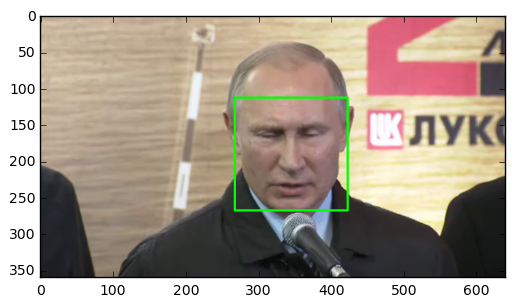

NEAREST NEIGHBORS IN ANNOY INDEX:
ID:	95;	FNAME:	0putin274.jpg;	DIST:	0.370


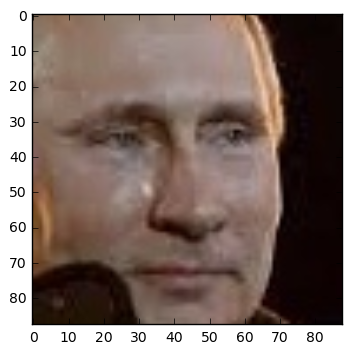

ID:	158;	FNAME:	0putin48.jpg;	DIST:	0.423


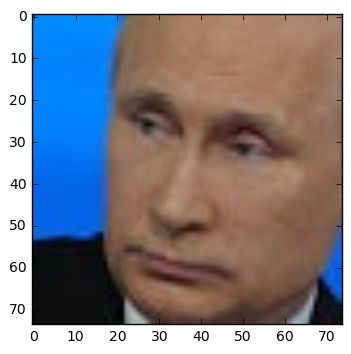

ID:	183;	FNAME:	0putin62.jpg;	DIST:	0.429


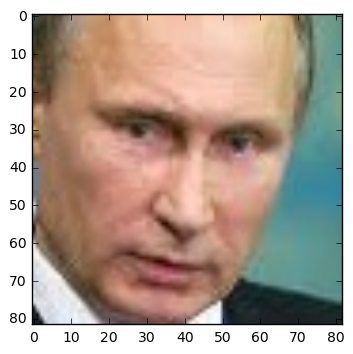

--------------------------------------------------


In [68]:
process_frame(frames_images[505])

In [77]:
import sklearn
from sklearn.metrics import precision_score, recall_score, f1_score
def compute_metrics(threshold, test_images, test_labels):
    predicted_labels = np.zeros(len(test_labels), dtype=np.int32)
    for i, image in enumerate(test_images):
        if i % 50 == 0:
            print i
        dists = find_nns(image)
        if dists is not None:
            if min(dists) <= threshold:
                predicted_labels[i] = 1
    metric_fns = [precision_score, recall_score, f1_score]
    metrics = [fn(test_labels, predicted_labels) for fn in metric_fns]
    return metrics

In [78]:
compute_metrics(0.6, frames_images, frames_labels)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700


[0.97199999999999998, 0.66032608695652173, 0.78640776699029125]

In [85]:
ths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
metrics = []
for threshold in ths:
    print threshold
    metrics.append(compute_metrics(threshold, frames_images, frames_labels))
    print metrics[-1]

0.1
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.0, 0.0, 0.0]
0.2
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
[0.0, 0.0, 0.0]
0.3
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
[1.0, 0.019021739130434784, 0.037333333333333336]
0.4
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
[1.0, 0.18478260869565216, 0.31192660550458717]
0.5
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
[1.0, 0.49728260869565216, 0.66424682395644286]
0.6
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
[0.97199999999999998, 0.66032608695652173, 0.78640776699029125]
0.7
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
[0.89905362776025233, 0.77445652173913049, 0.83211678832116776]
0.8
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
[0.81283422459893051, 0.82608695652173914, 0.81940700808625344]
0.9
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
[0.71363636363636362, 0.85326086956521741, 0.77722772277227714]
1.0
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
[0.64214711729622